# Loan Default Prediction in the Fannie Mae Single Family Loan Dataset

<center>Pengchong Tang  - Last updated on 07/17/2018</center>

## 1. Introduction

What is Fannie Mae? According to Wikipedia, "The Federal National Mortgage Association (FNMA), commonly known as Fannie Mae, is a United States government-sponsored enterprise (GSE) and, since 1968, a publicly traded company. Founded in 1938 during the Great Depression as part of the New Deal, the corporation's purpose is to expand the secondary mortgage market by securitizing mortgages in the form of mortgage-backed securities (MBS), allowing lenders to reinvest their assets into more lending and in effect increasing the number of lenders in the mortgage market by reducing the reliance on locally based savings and loan associations." 

Fannie Mae releases quarterly based single family fixed rate mortgage dataset on its website. The data is divided into acquisition files and performance files grouped quarterly ranging from year 2000 to 2017. The acquisition files contain static mortgage loan data at the time of the mortgage loan's origination and delivery to Fannie Mae, these files include personal information, loan amount, loan rate and other things. The performance files contain monthly performance data for each loan such as payment information, from acquisition up until its current status as of the previous quarter. 

Inspired by Kyle's notebook [see here](https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/), we can utilize the existance of the last status of each loan to determine whether it has defaulted. In this project, I am interested if we can use machine learning techniques to predict whether a loan will end as a default by the time we just know the origination information. I am going to explore the third quarter data of 2007 and make a model, to see if I can use this model to forecast the defaulted loan on the fourth quarter of 2007, which has the highest delinquency rate in the agency’s history – 19.4% versus the historical average of 1.7%.    

## 2. The Definition of Default

I don't find any description about Fannie Mae's official definition on the defaulted mortgage loan. But I've reviewed the codes of tutorial 101 provived by Fannie Mae, the Default UPB was calculated by a summation of the loans which has a zero balance code 
<br>
<br>
02 - Thrid Party 
<br>
03 - Short Sale
<br>
09 - Deed-in-Lieu REO Disposition
<br>
15 - Note Sale
<br>
<br>
when disposition date is not null. So the codes indicate we can just use these four ZB codes to define the defaulted loan then label them in the data set. Further, I will discuss how I define the non-defaulted loan.

## 3. Import and Clean the Dataset

Let's import the Python packages that need to be used in this project. 

In [47]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,auc,average_precision_score,accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

import xgboost as xgb
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("max_colwidth",1000000)
pd.set_option('max_columns', 50)

First, I will import the data set Acquisition_2007Q3.txt and Performance_2007Q3.txt. The performance data set contains 18 million records, accually we're just interested on the last record of each loan that shows the latest loan status. So I will drop those duplicate records then join the two data sets by the Loan_id. To save more time, I recommend saving the combined data set for the future use as the import process could take an hour thereby I don't need to load it everytime I re-open the notebook.

In [ ]:
Acquisitions_Variables =["LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE",
                         "FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", "PROP_TYP",
                         "NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", "RELOCATION_FLG"]

Performance_Variables = ["LOAN_ID", "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat",
                         "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
                         "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
                         "CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", 
                         "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"]

Acquisitions_ColClasses = ["str", "str", "str", "float", "float", "int", "str", "str", "float",
                           "float", "str", "float", "float", "str", "str", "str", "str", "str",
                           "str", "str", "float", "str", "float", "float", "str"]

Performance_ColClasses = ["str", "str", "str", "float", "float", "float", "float", "float", "str",
                          "str", "str", "str", "str", "str", "str", "str", "str",
                          "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", 
                          "float", "str", "float", "str"]

Acquisitions_dict=dict(zip(Acquisitions_Variables,Acquisitions_ColClasses))
Performance_dict=dict(zip(Performance_Variables,Performance_ColClasses))


Data_A= pd.read_csv('Acquisition_2007Q3.txt', sep='|', 
                    names=Acquisitions_Variables,
                    dtype=Acquisitions_dict,
                    parse_dates=["ORIG_DTE","FRST_DTE"],
                    index_col=False)
Data_P = pd.read_csv('Performance_2007Q3.txt', sep='|', 
                     names=Performance_Variables, 
                     dtype=Performance_dict,
                     parse_dates=["Maturity.Date","ZB_DTE", "LPI_DTE","FCC_DTE"],
                     index_col=False)


In [ ]:
Data_P.drop_duplicates(subset='LOAN_ID', keep='last', inplace=True)
Combined_Data = pd.merge(Data_A, Data_P, on='LOAN_ID', how='inner')

In [ ]:
Combined_Data.to_csv("Combined_Data_2007Q3.txt",sep='|',index=False,header=False)

Let's read the Combined_Data_2007Q3.txt again assumed you've open a new notebook. This time we can exclude some variables originally from the performance data set which are not relevant to origination and the loan result. I only import Delq.Status, DISP_DT, Zero.Bal.Code (ZB) from the performance data set. The Combined_Data has 314603 loans and 24 variables.

In [2]:
Combined_Variables =["LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", 
                     "ORIG_DTE","FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "DTI", "CSCORE_B", 
                     "FTHB_FLG", "PURPOSE", "PROP_TYP","NUM_UNIT", "OCC_STAT", 
                     "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", 
                     "RELOCATION_FLG",
                     
                     "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age",
                     "Months.To.Legal.Mat", "Adj.Month.To.Mat", "Maturity.Date", "MSA", 
                     "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", "ZB_DTE", "LPI_DTE", 
                     "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", 
                     "TAX_COST", "NS_PROCS","CE_PROCS", "RMW_PROCS", "O_PROCS", 
                     "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH",
                     "TRANSFER_FLG"]

Combined_ColClasses = ["str", "str", "str", "float", "float", "int", "str", "str", "float", 
                       "float", "str", "float", "float", "str", "str", "str", "str", "str",
                       "str", "str", "float", "str", "float", "float", "str",

                       "str", "str", "float", "float", "float", "float", "float", "str",
                       "str", "str", "str", "str", "str", "str", "str", "str",
                       "float", "float", "float", "float", "float", "float", "float", 
                       "float", "float", "float", "float", "str", "float", "str"]

Combined_dict=dict(zip(Combined_Variables,Combined_ColClasses))
#Combined_date_cols=["ORIG_DTE","FRST_DTE","Maturity.Date","ZB_DTE", "LPI_DTE","FCC_DTE"]
Combined_date_cols=["ORIG_DTE","FRST_DTE"]

Combined_Data= pd.read_csv('Combined_Data_2007Q3.txt', sep='|', 
                    names=Combined_Variables, 
                     dtype=Combined_dict,
                     parse_dates=Combined_date_cols,
                     usecols=list(range(25))+[34,36,40],     
                    index_col=False)


In [3]:
Combined_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314723 entries, 0 to 314722
Data columns (total 28 columns):
LOAN_ID           314723 non-null object
ORIG_CHN          314723 non-null object
Seller.Name       314723 non-null object
ORIG_RT           314723 non-null float64
ORIG_AMT          314723 non-null float64
ORIG_TRM          314723 non-null int32
ORIG_DTE          314723 non-null datetime64[ns]
FRST_DTE          314723 non-null datetime64[ns]
OLTV              314723 non-null float64
OCLTV             314723 non-null float64
NUM_BO            314713 non-null object
DTI               305580 non-null float64
CSCORE_B          314084 non-null float64
FTHB_FLG          314723 non-null object
PURPOSE           314723 non-null object
PROP_TYP          314723 non-null object
NUM_UNIT          314723 non-null object
OCC_STAT          314723 non-null object
STATE             314723 non-null object
ZIP_3             314723 non-null object
MI_PCT            55596 non-null float64
Product

### 3.1 Cleaning the Columns

Let's create some calculated variables according to Fannie Mae's tutorial. ORIG_VAL is the original home value, which can be easily calulated from the original loan amount and the original loan-to-value. I also create the OCLTV and combine the borrower credit scoreas and the co-borrower credit score into the minimum credit score CSCORE_MN, the calculation is referred to Fannie Mae's tutorial. 

In [4]:
Combined_Data['ORIG_VAL']=Combined_Data['ORIG_AMT']/(Combined_Data['OLTV']/100)
Combined_Data['OCLTV']=Combined_Data.apply(lambda row : row['OLTV'] if row['OCLTV']==np.nan else row['OCLTV'],axis=1)

Combined_Data['CSCORE_MN']=Combined_Data.apply(lambda row : min(row['CSCORE_B'],row['CSCORE_C']) ,axis=1)

# Combined_Data['VinYr']=Combined_Data['ORIG_DTE'].dt.year
# Combined_Data['ORIG_DTE_month']=Combined_Data['ORIG_DTE'].dt.month

# Combined_Data['FRST_DTE_year']=Combined_Data['FRST_DTE'].dt.year
# Combined_Data['FRST_DTE_month']=Combined_Data['FRST_DTE'].dt.month

There is a variable ZIP_3 that contains the first 3 digit zipcode of the loan origination location. If we include this feature into the model regarding as categorical feature, we need to create tons of dummy variables to represent each zipcode. After doing some research, I found a way that we can transfer the 3 digit zipcode into numeric coordinates so that we just need two continuous variables latitude and longitude to represent the zipcodes, as well as the latitude and longitude are much better for visualization.
<br>
<br>
Let's look at the ZIP_3 column:

In [5]:
Combined_Data['ZIP_3'].value_counts(dropna=False)

606    3388
600    2799
300    2706
750    2687
852    2382
601    2375
840    2188
604    2098
770    1936
481    1916
980    1877
853    1860
080    1806
605    1719
850    1632
117    1589
301    1526
773    1487
212    1480
331    1466
787    1460
917    1432
330    1418
774    1417
972    1417
190    1372
275    1370
631    1369
334    1354
327    1348
       ... 
266       9
792       9
739       8
879       8
167       7
413       7
369       7
408       5
256       5
669       5
884       4
102       4
576       4
059       3
332       3
414       2
692       2
000       2
418       2
867       2
248       2
099       1
885       1
966       1
353       1
854       1
733       1
632       1
821       1
090       1
Name: ZIP_3, dtype: int64

I notice there are two zipcode 000 in the data set, that must be erroneous entry because 000 has not been used by USPS. And the STATE variable shows that these two records are from PR and FL, respectively, so this confirms the incorrect data. We can adjust the 000 and make them as missing values.

In [6]:
Combined_Data.loc[Combined_Data['ZIP_3']=="000",'ZIP_3']=np.nan
Combined_Data['ZIP_3']=Combined_Data['ZIP_3'].astype(str)

I create a table that maps the zipcode to the coordinates using the Python package uszipcodes, then calculate the centroid coordinates for each 3 digit zip code.I join this table with the Combined_Data.

In [7]:
# Find all zipcodes
res = search.by_coordinate(39.122229, -77.133578, radius=99999, returns=99999)

zip_list=[]
for i in res:
    zip_list.append({'Zipcode': i.Zipcode,'Latitude': i.Latitude,'Longitude':i.Longitude,'ZIP_3':i.Zipcode[:3]})

allzipcodes=pd.DataFrame.from_dict(zip_list)

all3zipcodes=allzipcodes.groupby(['ZIP_3']).mean().reset_index()


Combined_Data=pd.merge(Combined_Data,all3zipcodes,on='ZIP_3', how='inner')

Now we almost finish the column cleaning. We need to drop some unused columns. MI_TYPE and MI_PCT has too many missing values, LOAN_ID and a constant Product.Type do not tell any information. We have calculated the CSCORE_MN and the coordinates, so the CSCORE_B, CSCORE_C, ZIP_3 can be removed. Futhermore, the purpose of this project is to predict the loan across quarters, so the time variables might not be useful. I am exploring for a time travelling truth, so I decide to drop ORIG_DTE and FRST_DTE. Although the exact time is not being considered, I might ignore some cycling pattern that occurs seasonly, or even quarterly, I bet it would not happen.

In [8]:
drop_acquisition=["LOAN_ID","ZIP_3","MI_TYPE","MI_PCT","CSCORE_B","CSCORE_C","Product.Type","ORIG_DTE","FRST_DTE"]
Combined_Data.drop(drop_acquisition, axis=1, inplace=True)

### 3.2 Cleaning the Rows

As we discussed previouly, the default can be identified if we filter out with the four ZB codes as well as a not null disposition date. So what about the non-defaulted loan? Are the other loans healthy? Let's take a look on the distribution of Zero Balance codes.

In [9]:
Combined_Data['Zero.Bal.Code'].value_counts(dropna=False)

01     254314
NaN     32656
09      17116
03       5809
06       2026
02       1041
16        897
15        744
Name: Zero.Bal.Code, dtype: int64

Besides the default loan's code, the 'good' codes 01, 06, 16 look like they have a current healthy loan status, but the data does not tell their final status, a good loan might lead to default if the borrower lost the income and can't pay the debt. We also notice 32656 loans without a ZB code, which means a delinquency occurs. Let's look at Delq.Status.

In [10]:
Combined_Data['Delq.Status'].value_counts(dropna=False)

X      257237
0       27433
NaN     24710
1        2274
2         789
3         464
4         314
5         173
6         121
7          93
8          92
9          85
11         64
14         49
10         46
12         45
16         40
13         37
15         31
17         29
18         24
19         22
20         19
27         17
24         15
21         14
22         14
25         13
23         12
26         11
        ...  
48          2
59          2
58          2
115         2
88          2
42          2
71          2
62          2
84          2
93          2
110         2
108         2
83          2
63          2
54          1
74          1
104         1
121         1
99          1
124         1
100         1
55          1
44          1
123         1
120         1
64          1
95          1
92          1
102         1
72          1
Name: Delq.Status, dtype: int64

In [11]:
Combined_Data[(Combined_Data['Delq.Status']!="X") & (Combined_Data['Delq.Status'].notnull())].shape

(32656, 23)

In [12]:
Combined_Data.astype(str).groupby(['Delq.Status','Zero.Bal.Code']).size()

Delq.Status  Zero.Bal.Code
0            nan               27433
1            nan                2274
10           nan                  46
100          nan                   1
101          nan                   4
102          nan                   1
104          nan                   1
105          nan                   4
106          nan                   4
107          nan                   3
108          nan                   2
109          nan                   3
11           nan                  64
110          nan                   2
111          nan                   5
114          nan                   3
115          nan                   2
117          nan                   3
12           nan                  45
120          nan                   1
121          nan                   1
123          nan                   1
124          nan                   1
13           nan                  37
14           nan                  49
15           nan                  31
16         

The delinquency status shows the number of months that the borrower is delinquent. We see 32656 loans having delinquent months and the number matches the number of missing ZB code, which indicates the loans are slightly or severely unhealthy. There are 24710 loans with missing delinquency status, they all have the defaulted ZB codes. A status X indicates an unknown delinquency status, these loans are probably in a healthy status, Fannie Mae assigns them with ZB codes 01, 06 ,16. Now we know all the loan status:
<br>
<br>
Good loans or currently healthy loans: 257237
<br>
Confirmed defaulted loans: 24710
<br>
Unhealthy loans:  32656
<br>
<br>
The defaulted loans are clear on definition while I don't see Fannie Mae's data set has the final confirmation on the good loans. Should we label the unhealthy loans as good loans? Of course no, some article indicates the mortgage payers having more than 3 months delinquency will invariantly end up in default. It's hard to determine the final status for these unhealthly loans, they are in ambiguous status though trend to default. To reduce noisy data on the modelling, I would like to exclude these unhealthy loans. Now let's filter out our training data by labelling the classes, the defaulted loans are labelled as 1, the current healthy loans are labelled as 0.

In [13]:
Combined_Data['Default']=Combined_Data.apply(lambda row : 1 
                                             if row['Zero.Bal.Code'] in ['02','03','09','15'] and str(row['DISP_DT'])!='NaT' 
                                             else (0 if row['Zero.Bal.Code'] in ['01','06','16'] else np.nan),axis=1)
Combined_Data['Default'].value_counts(dropna=False)

 0.0    257237
NaN      32656
 1.0     24710
Name: Default, dtype: int64

In [14]:
Combined_Data=Combined_Data[Combined_Data['Default'].notnull()]
Combined_Data['Default'].value_counts(dropna=False)

0.0    257237
1.0     24710
Name: Default, dtype: int64

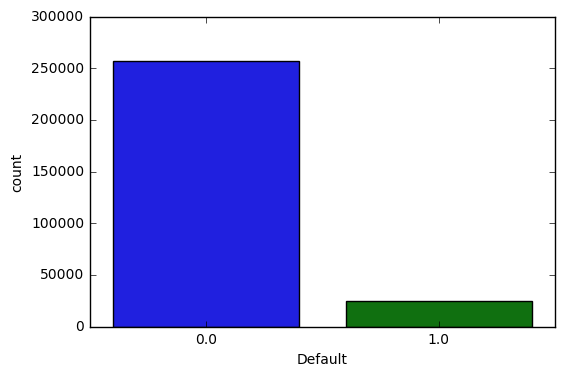

In [15]:
sns.countplot(Combined_Data['Default'])

The defaulted loans account for 8.7% of the total loans in third quarter of 2007. The training data is imbalanced for each class.

### 3.3 Check Missing Values

Let's check any missing values in the Combined_Data.

In [16]:
Combined_Data.apply(lambda x: x.isnull().sum(), axis=0)

ORIG_CHN               0
Seller.Name            0
ORIG_RT                0
ORIG_AMT               0
ORIG_TRM               0
OLTV                   0
OCLTV                  0
NUM_BO                 5
DTI                 8107
FTHB_FLG               0
PURPOSE                0
PROP_TYP               0
NUM_UNIT               0
OCC_STAT               0
STATE                  0
RELOCATION_FLG         0
Delq.Status        24710
Zero.Bal.Code          0
DISP_DT           257702
ORIG_VAL               0
CSCORE_MN            544
Latitude               0
Longitude              0
Default                0
dtype: int64

We will finally drop Delq.status and DISP_DT. DTI, NUM_BO and CSCORE_MN have some values missing, later I will implement an XGBOOST, which is popular among the Kaggle competition. According to the author, XGBOOST can naturally adpet to a sparse feature and automatically learn what the best direction is to go when a value is missing. So I would not worry about these.  

## 4. Exploratory Analysis

Let's plot the Default column against other categorical variables to see how the default loans are distributed.

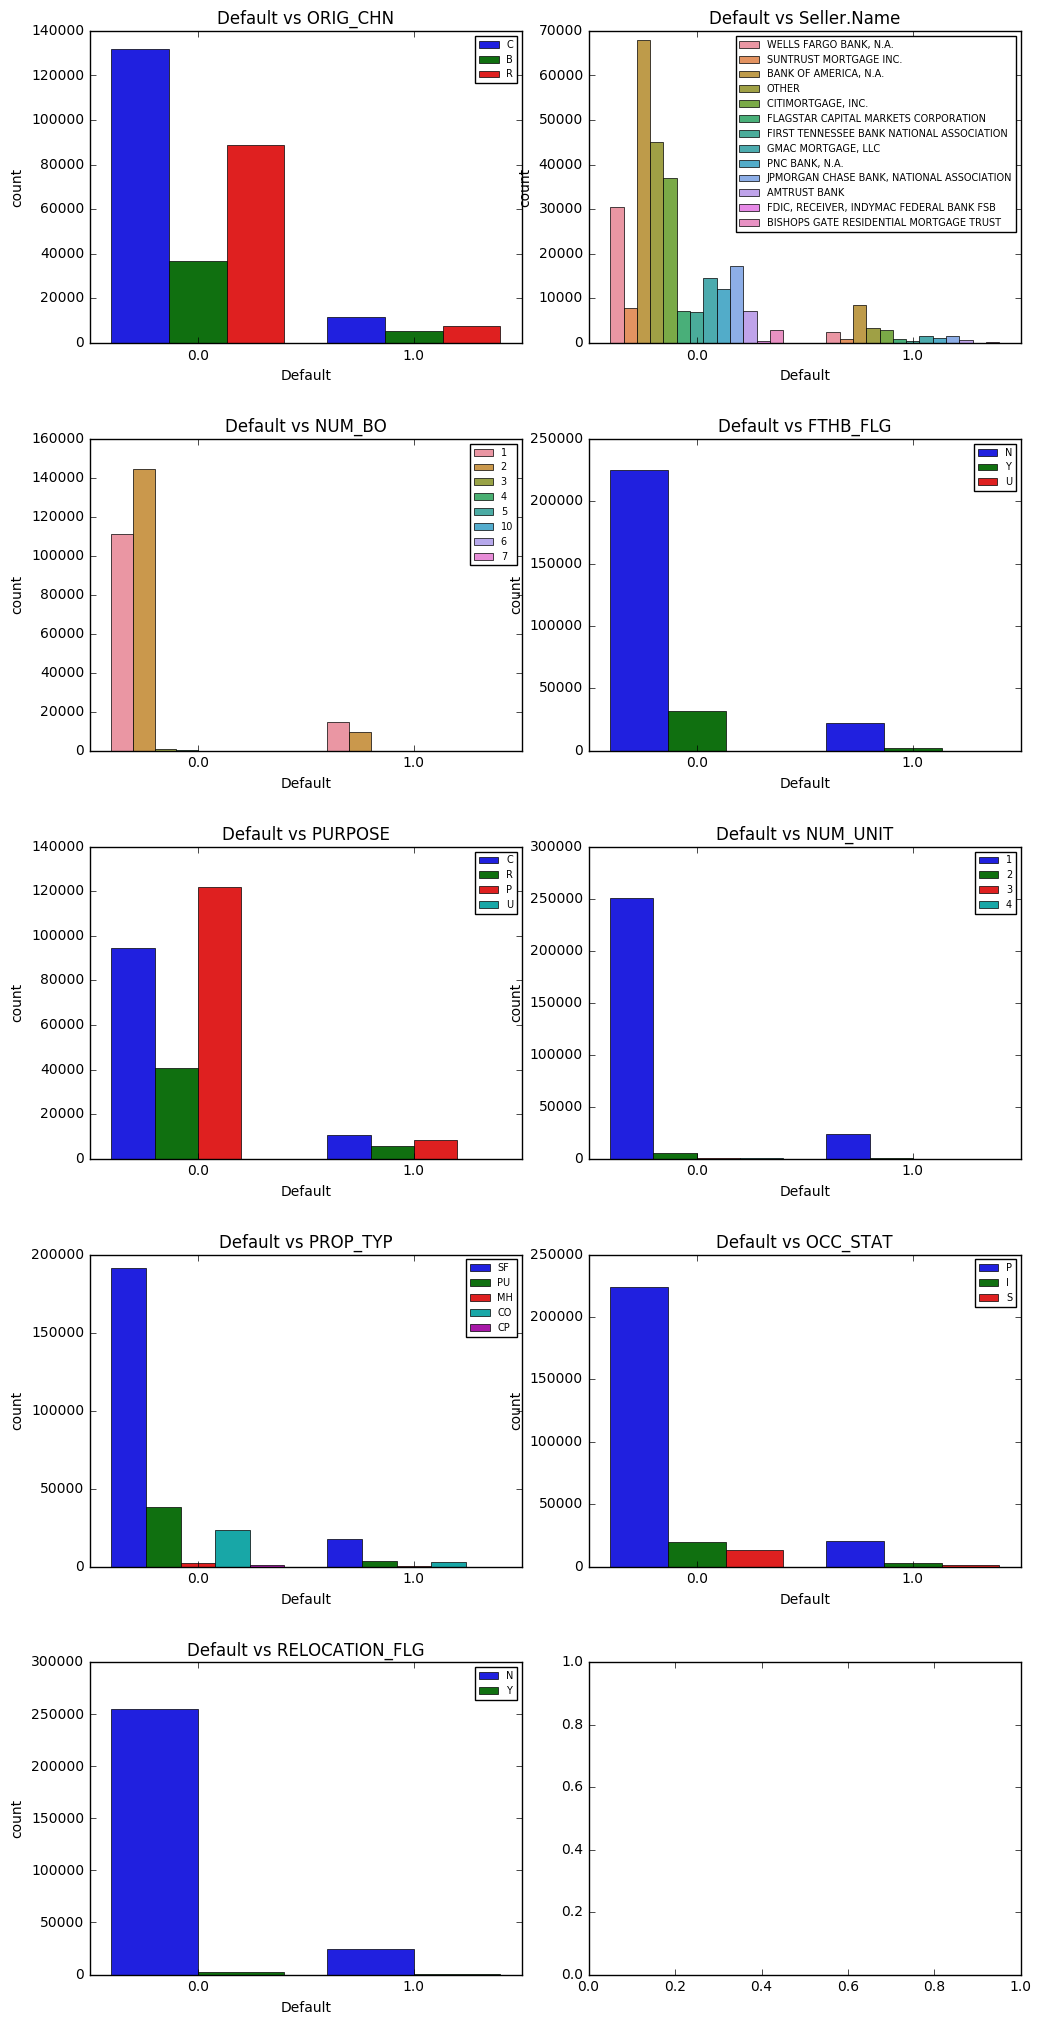

In [17]:
columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE","NUM_UNIT","PROP_TYP","OCC_STAT","RELOCATION_FLG"]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,10), columns):
    plt.subplot(5,2,i)
    ax=sns.countplot(x="Default", hue=column, data=Combined_Data, linewidth=0.5)

    ax.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 7})
    plt.xlabel('Default')
# plt.legend(loc="upper right",fontsize="xx-small")


It seems the categorical variables have almost the same distribution between two classes except for the NUM_BO. It looks like most loans got defaulted because of only one borrower who can't make the payments as well as no co-borrower can help this person. A loan having co-borrowers seems more safe.
<br>
<br>
How about the continuous variables? Let's make density plots on continuous variables againt the Default.

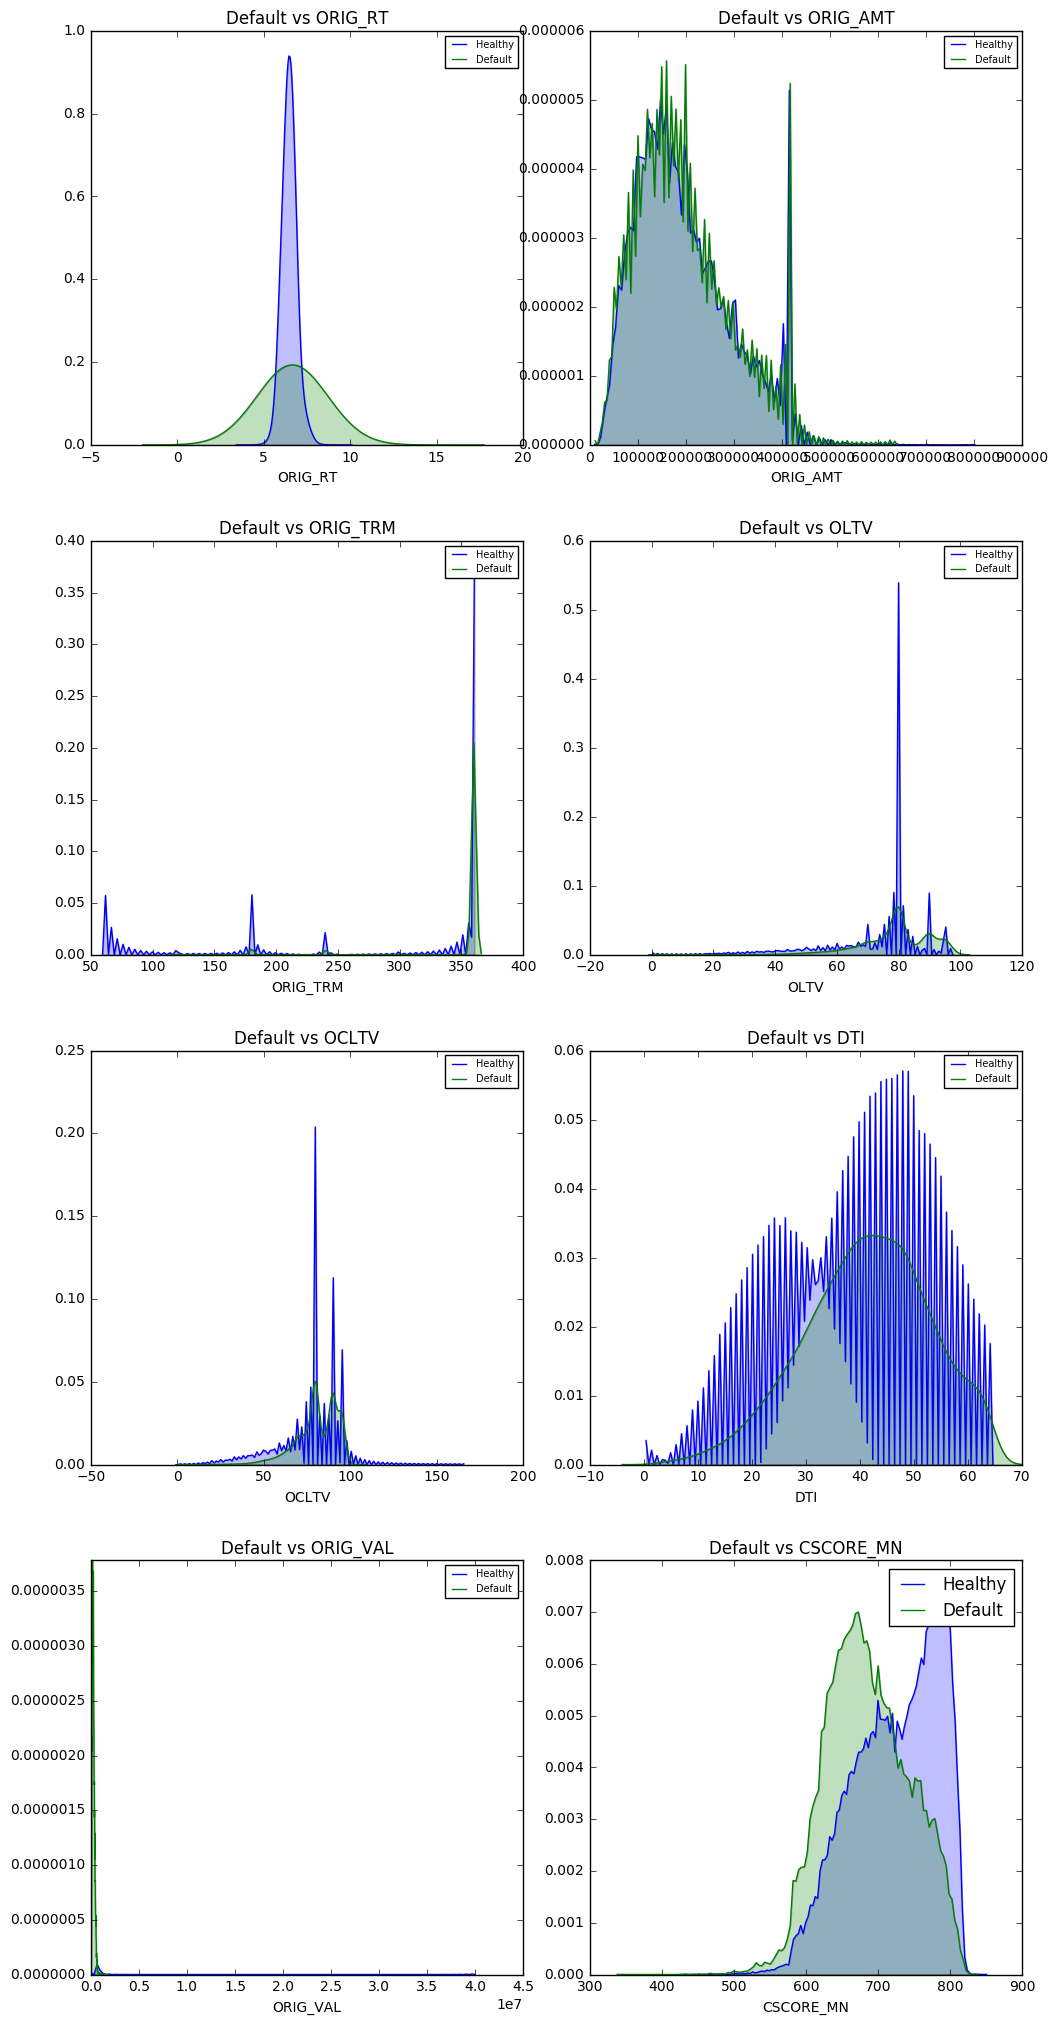

In [18]:
columns = ["ORIG_RT","ORIG_AMT","ORIG_TRM","OLTV","OCLTV","DTI","ORIG_VAL","CSCORE_MN"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,9), columns):
    plt.subplot(4,2,i)
    p1=sns.kdeplot(Combined_Data[Combined_Data['Default']==0][column], bw=.2, label="Healthy",shade=True)
    p2=sns.kdeplot(Combined_Data[Combined_Data['Default']==1][column], bw=2, label="Default",shade=True)

    p1.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 7})
    plt.xlabel(column)
plt.legend()

The figures show the default loan in green, and the healthy loan in blue. The distribution of ORIG_AMT, ORIG_VAL, OLTV, OCLTV, ORIG_TRM, DTI have extreme shapes, either high peak or severely skewed. Let's perform logarithm transformation over the plots, we need to view the data close to a normality.

In [19]:
Combined_Data['log_ORIG_VAL']=np.log(Combined_Data['ORIG_VAL'])
Combined_Data['log_ORIG_AMT']=np.log(Combined_Data['ORIG_AMT'])
Combined_Data['log_OLTV']=np.log(Combined_Data['OLTV'])
Combined_Data['log_ORIG_TRM']=-np.log(Combined_Data['ORIG_TRM'])
Combined_Data['log_OCLTV']=np.log(Combined_Data['OCLTV'])
Combined_Data['log_DTI']=np.log(Combined_Data['DTI'])

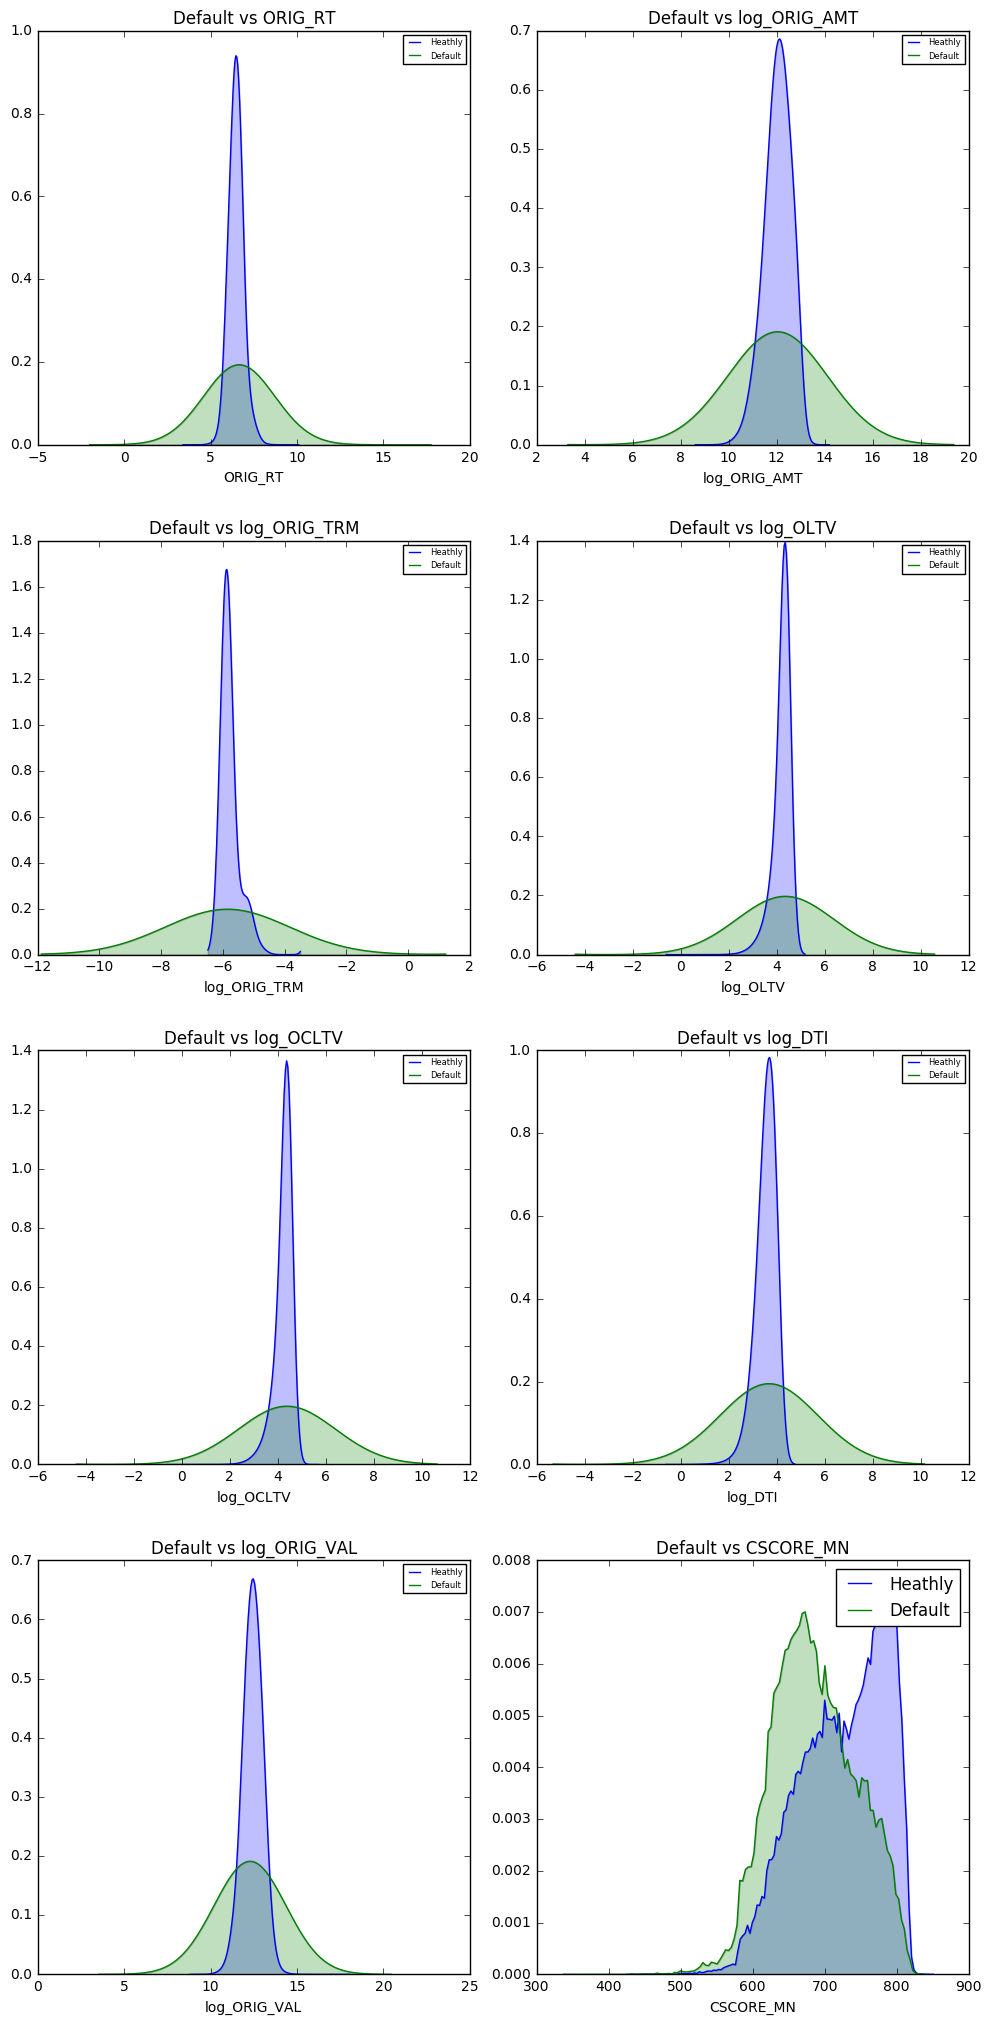

In [20]:
columns = ["ORIG_RT","log_ORIG_AMT","log_ORIG_TRM","log_OLTV","log_OCLTV","log_DTI","log_ORIG_VAL","CSCORE_MN"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,9), columns):
    plt.subplot(4,2,i)
    p1=sns.kdeplot(Combined_Data[Combined_Data['Default']==0][column], bw=.2, label="Heathly",shade=True)
    p2=sns.kdeplot(Combined_Data[Combined_Data['Default']==1][column], bw=2, label="Default",shade=True)

    p1.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 6})
    plt.xlabel(column)
plt.legend()

The figures show the distributions of the columns ORIG_RT, ORIG_AMT, ORIG_TRM, OCLTV, OLTV, DTI, ORIG_VAL, have a close mean between two classes, the default loans tend to have a bigger variance than the healthy loans. The minimum credit score CSCORE_MN appears distinguishable distributions between two classes, the default loan borrowers have a lower average credit score.

Next, we look at the default rate by the number of loan among different geographical location. Note that here my default rate is different from Fannie Mae's definition, which is the default UPB divided by the origination UPB. Let's plot the default rate for each STATE.

In [21]:
df=Combined_Data.groupby(['STATE','Default']).size()
df2=df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
df2=df2[df2['Default']==1].sort_values(by=[0],ascending=False)

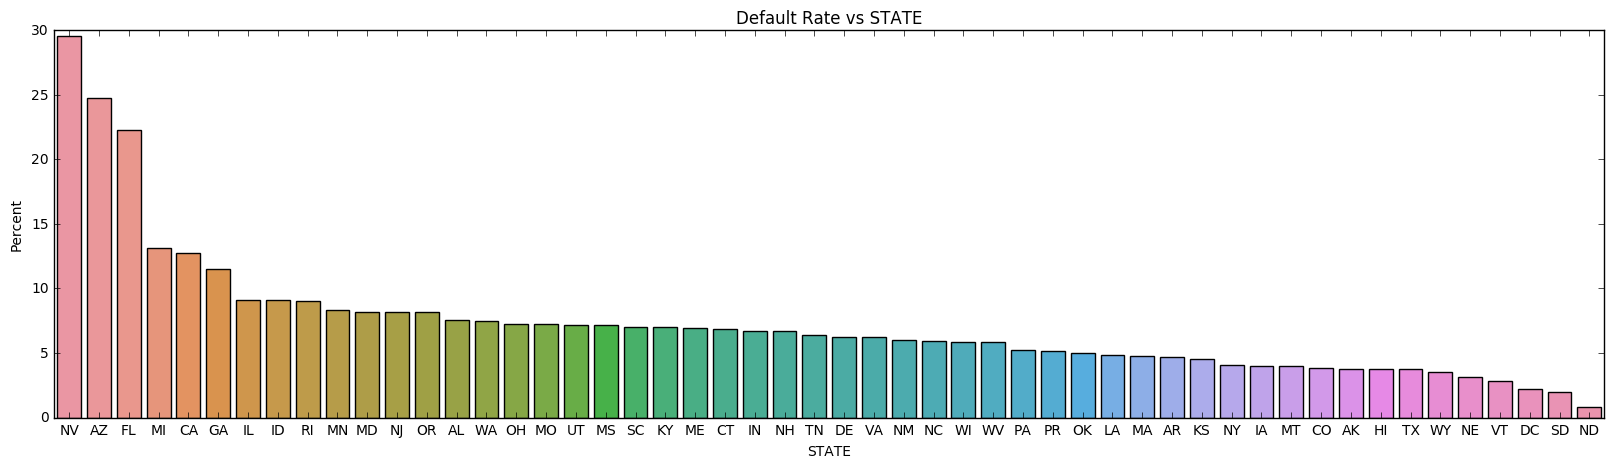

In [22]:
f, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(x="STATE",y=0, data=df2)
ax.set(ylabel="Percent")
ax.set_title("Default Rate vs STATE")

Nevada has the highest nearly 30% default rate while North Dakota has the minimum rate of defaulted loan. 
<br>
<br>
Now let's see the default rate for each zip code prefix area.

In [23]:
df=Combined_Data.groupby(['Latitude','Longitude','Default']).size().to_frame('rate')
df2=df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).reset_index()
df2=df2[df2['Default']==1].sort_values(by=['rate'],ascending=False)

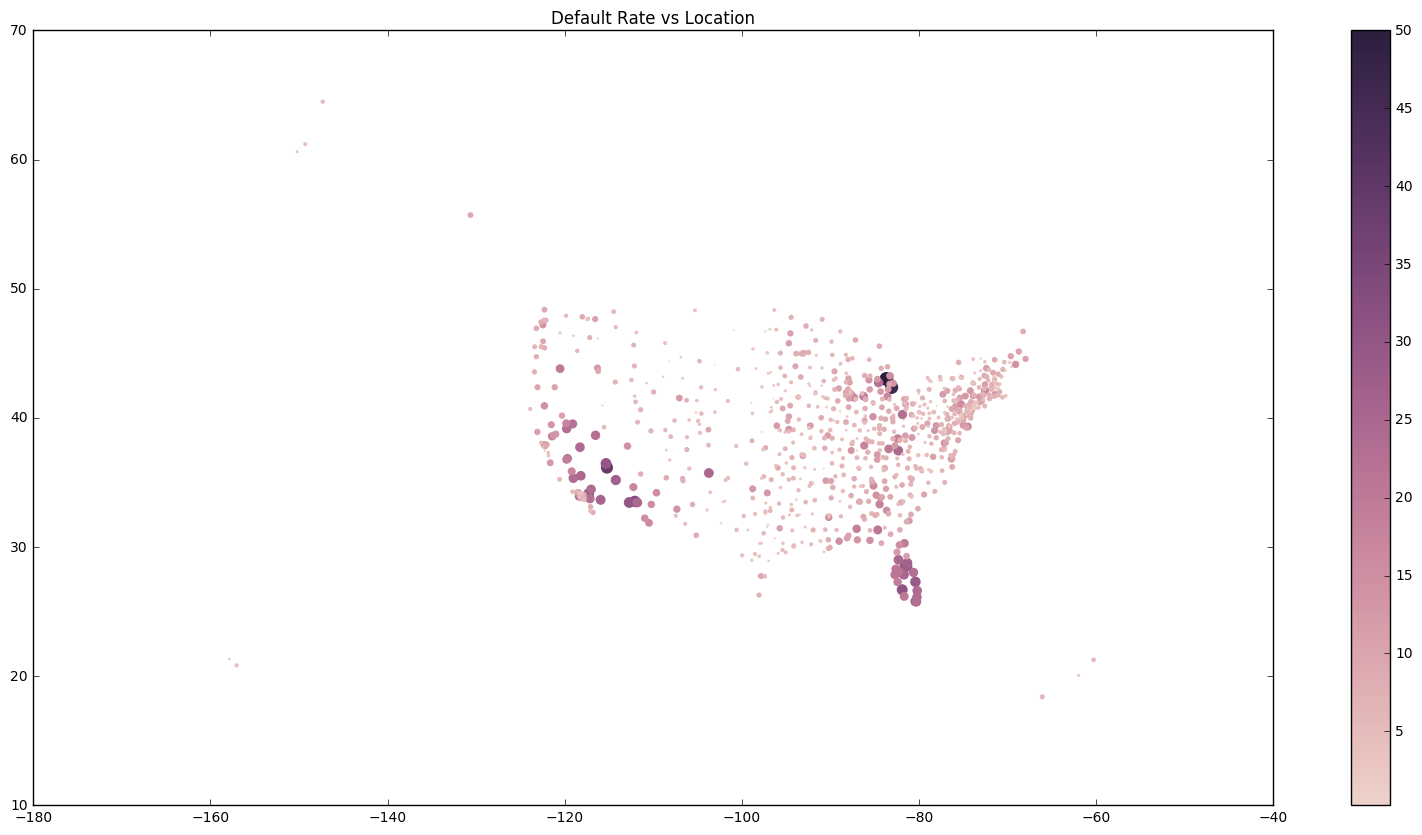

In [24]:
f, ax = plt.subplots(figsize=(20,10))

cmap = sns.cubehelix_palette(as_cmap=True)
area=df2['rate']*2

p=ax.scatter(x="Longitude",y="Latitude", 
             c='rate', 
             data=df2,
             edgecolors='none',
             s=area,
             cmap=cmap
                )
f.colorbar(p)
plt.title("Default Rate vs Location")

The figure shows a higher default rate area has a bigger circle and deeper color. We can see the deep color areas are southern California, Nevada, Arizona, Florida, and southeast Michigan. The deepest color on the map is at Flint, MI area which has a crazy 50% default rate.

# 5. Prediction with XGBOOST

### 5.1 Creating Dummy Variables and Cleaning Unused Columns

Before modelling, we need to convert the categorical columns into dummy features. Then we need to finally drop all unused features from the data set.

In [25]:
columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE",
            "NUM_UNIT","PROP_TYP","STATE",'RELOCATION_FLG','OCC_STAT']
for column in columns:
    temp=pd.get_dummies(Combined_Data[column],prefix=column,drop_first =True)
    Combined_Data = pd.concat([Combined_Data,temp],axis=1)
    Combined_Data = Combined_Data.drop([column], axis=1)

In [26]:
# final drop

columns=['ORIG_AMT', 'ORIG_TRM', 'OLTV', 'OCLTV', 'DTI','ORIG_VAL','Zero.Bal.Code','DISP_DT','Delq.Status']

Combined_Data.drop(columns, axis=1, inplace=True)

In [27]:
Combined_Data.shape

(281947, 98)

### 5.2 Modelling and Evaluation

Now we split the Combined_Data into a feature matrix X and the Default column was converted to a reponse vector y. Then we randomly split X, y into a training set and a validation set.

In [28]:
y = Combined_Data['Default'].values
X = Combined_Data.drop(['Default'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0,stratify=y)

Now we define the XGBClassifier with 1000 trees and an early stopping module to prevent the model from overfitting. The early stopping module predicts the validation set, uses the metric Area Under the Precision-Recall Curve (AUPRC) to evaluate the model performance. If the validation set error is not improved for 5 iteration, the iteration process will be stopped. AUPRC is one of the metrics used for anomaly detection, which is more sensitive to the small difference of a minor class. Also, the scale_pos_weight attribute in XGBOOST is for balancing each class, we should set an appropiate positive number to increase the weight of the minor class.

In [29]:
model = xgb.XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4,
    scale_pos_weight=4.5,
    seed=27,
    max_depth = 5,
    min_child_weight = 5
)

def evalauc(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    area = auc(recall, precision)
    return 'AUPRC', -area


model.fit(X_train, y_train,
          eval_metric=evalauc,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=5,
         verbose=True) 


[0]	validation_0-error:0.119394	validation_1-error:0.121668	validation_0-AUPRC:-0.252463	validation_1-AUPRC:-0.24023
Multiple eval metrics have been passed: 'validation_1-AUPRC' will be used for early stopping.

Will train until validation_1-AUPRC hasn't improved in 5 rounds.
[1]	validation_0-error:0.105377	validation_1-error:0.106474	validation_0-AUPRC:-0.265421	validation_1-AUPRC:-0.25103
[2]	validation_0-error:0.10741	validation_1-error:0.10968	validation_0-AUPRC:-0.291957	validation_1-AUPRC:-0.272489
[3]	validation_0-error:0.108924	validation_1-error:0.11046	validation_0-AUPRC:-0.299299	validation_1-AUPRC:-0.279854
[4]	validation_0-error:0.107311	validation_1-error:0.108871	validation_0-AUPRC:-0.299635	validation_1-AUPRC:-0.280634
[5]	validation_0-error:0.106852	validation_1-error:0.108332	validation_0-AUPRC:-0.307765	validation_1-AUPRC:-0.288203
[6]	validation_0-error:0.107793	validation_1-error:0.108871	validation_0-AUPRC:-0.315485	validation_1-AUPRC:-0.294488
[7]	validation_0-er

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=4.5, seed=27,
       silent=True, subsample=0.8)

We've fitted the model with training set. Now we can print the confusion matrix and the report to see the model performance on predicting the validation dataset.

In [30]:
predict = model.predict(X_test)
print(classification_report(y_test, predict))
print(confusion_matrix(y_test,predict))
print("Accuracy: ")
print(accuracy_score(y_test,predict))

             precision    recall  f1-score   support

        0.0       0.95      0.90      0.92     64309
        1.0       0.33      0.52      0.40      6178

avg / total       0.90      0.86      0.88     70487

[[57669  6640]
 [ 2971  3207]]
Accuracy: 
0.863648616057


The confusion matrix shows that the model is able to find out 3271 of 6178 defaulted loan from the validation dataset, which means 52% of the defaulted loans are found. There are 2971 defaulted loans being ignored, so the recall is 0.52. However, the model also incorrectly classifies 6640 loans as default, the precision of default is only 0.33.

The report also shows the model achieves an 86% prediction accuracy. But due to unbalanced classes, the accuracy is not important to evaluate the model, as we know, a dummy model classifying all loans as healthy loan can achieve a 91.3% accuracy.

Let's take a look the AUPRC figure.

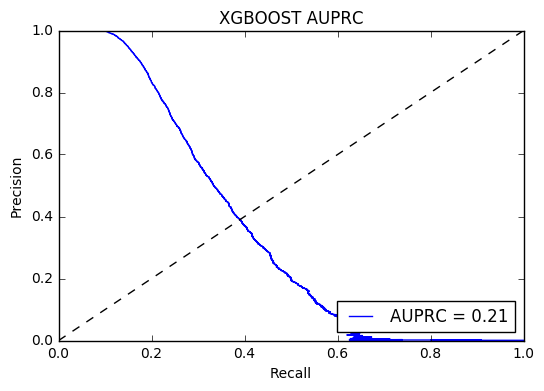

In [78]:
fpr, tpr, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
auprc = average_precision_score(y_test, predict)

plt.plot(fpr, tpr, lw=1, label='AUPRC = %0.2f'%(auprc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBOOST AUPRC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

The AUPRC value is only 0.21, which tells model has a poor performance on distinguishing the default.

Some articles use the area under the ROC curve as the metric, but I don't suggest that because the goal is to identify the default while the model also have a high accuracy prediction on the healthy loans, the area under the ROC curve will average the performance on both classes, so we will see the score below, a score 0.71 for this model, which can be regarded as a fair classifier. 

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001CC16500B38>>
Traceback (most recent call last):
  File "C:\Users\TANGP05\AppData\Local\Continuum\Anaconda3\lib\site-packages\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


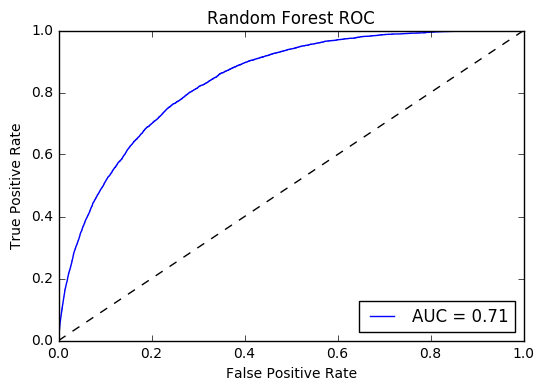

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

The area under the ROC curve is 0.71. It looks like the model is not so bad, a fair classifier that at least is able to find out most healthy loan, but it does not show how poorly it detects the default.

Finally we check the feature importance from XGBOOST.

In [39]:
feature_name=Combined_Data.columns.tolist()
feature_name.remove('Default')
dtrain = xgb.DMatrix(X, label=y,feature_names=feature_name)

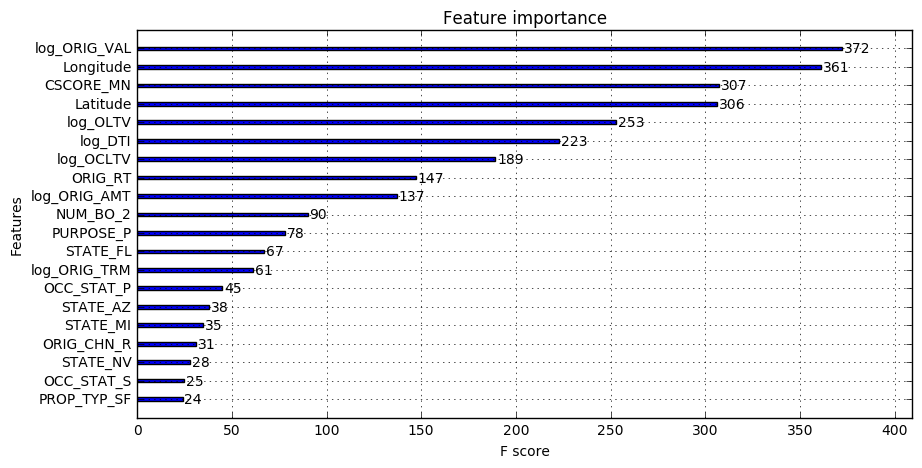

In [38]:
model.get_booster().get_score().items()
mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in model.get_booster().get_score().items()}
fig,ax  =  plt.subplots (figsize=(10, 5))
xgb.plot_importance(mapped, max_num_features=20,ax=ax)
plt.show()

We can see the top features, the house value, credit score, location and loan-to-value are the important features.

### 5.3 Predtiction on 2007Q4

Let's use the model the predict the 2007Q4 data. I've prepared for the a pre-cleaned Combined_Data set similar to 2007Q3. Now we just need to read the pre-cleaned data set.

In [41]:
Combined_Data_2007Q4=pd.read_csv("Combined_Data_cleaned_2007Q4.txt",sep="|")

Check how many defaulted and healthy loans in 2007Q4.

In [42]:
Combined_Data_2007Q4['Default'].value_counts(dropna=False)

0.0    311135
1.0     36151
Name: Default, dtype: int64

The defaulted loans account for 10.4%, a small increase from the third quarter. Now we predict this data and check the results.

In [43]:
y = Combined_Data_2007Q4['Default'].values
X = Combined_Data_2007Q4.drop(['Default'], axis=1).values

In [44]:
predict = model.predict(X)
print(classification_report(y, predict))
print(confusion_matrix(y,predict))
print(accuracy_score(y,predict))

             precision    recall  f1-score   support

        0.0       0.95      0.82      0.88    311135
        1.0       0.29      0.63      0.40     36151

avg / total       0.88      0.80      0.83    347286

[[255215  55920]
 [ 13260  22891]]
0.800798189389


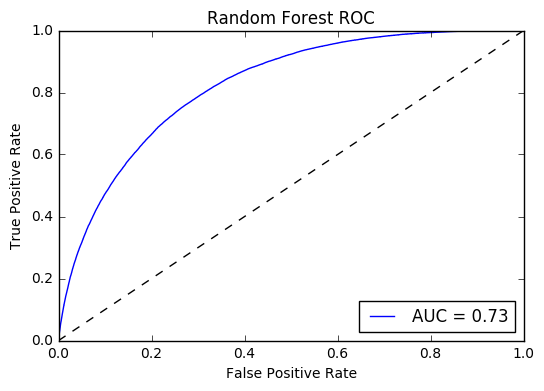

In [45]:
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
roc_auc = roc_auc_score(y, predict)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

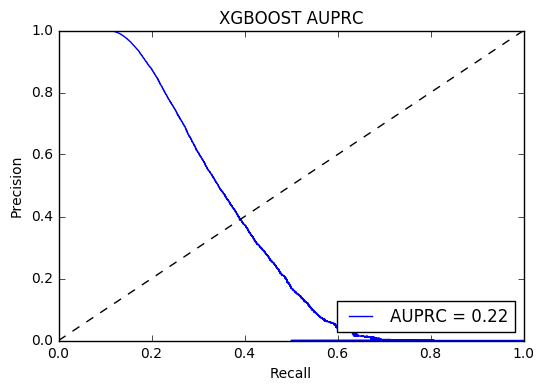

In [46]:
fpr, tpr, thresholds = precision_recall_curve(y, model.predict_proba(X)[:,1])
auprc = average_precision_score(y, predict)

plt.plot(fpr, tpr, lw=1, label='AUPRC = %0.2f'%(auprc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBOOST AUPRC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

Looking into those results, the prediction achieves 0.29 presicion and 0.69 recall, quite similar score compared to the validation set. We can conclude this is a robust model carried into the test data set.

## 6. Conclusion

In this project, we've implemented a machine learning model to predict the defaulted loans across quarter. The model gave us excellent prediction on the healthy loans, however, its performance on finding the defaulted loans is not good enough as I expected. The default precision and recall scores are around or below 0.5, many misclassifications occur on the boundry between the defaulted and the healthy. The result seems to indicate a pattern that we can narrow down a portion of highly risky loans by using the machine learning algorithm, whose final loan status randomly become defaulted but we currently don't know what factor causes them defaulted. We may need to include more data and expand our analysis on more external factors besides the data set available on Fannie Mae's website, for example, we could download more data from Fannie Mae's website, we can explore some economic factors such as local unemployment rate, or gather more backgrounds about the loans. Moreover, we can improve the XGBOOST model by tuning the parameters, although the improvement may not be significant than finding an important feature. Some articles indicate the unpredictable exogenous shocks have great impact on the economy, making environment data reshaped but the model fail to detect the changes of outside climate as well as hard to make an accurate prediction.

## 7. References

https://github.com/dmlc/xgboost/issues/21

http://www.fanniemae.com/resources/file/fundmarket/pdf/webinar-101.pdf

https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf

https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/

http://economics.ucr.edu/job_candidates/Bagherpour-Paper.pdf

http://www.iadisportal.org/digital-library/mdownload/predicting-mortgage-default-lessons-from-data-mining-fannie-mae-mortgage-portfolio

https://en.wikipedia.org/wiki/Fannie_Mae

http://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html